# _PROJECT_: Adversarial Collab: Political Belief Updating

In [1]:
# Core analysis packages

from pandas import ExcelWriter
from pandas import ExcelFile
from statsmodels.formula.api import ols
import pingouin as pg
import researchpy

import numpy as np
import os, sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import anova
from patsy import dmatrices
import bff
# Plotting packages
import matplotlib.pyplot as plt; plt.rcdefaults()
import seaborn as sns 
sns.set(style="ticks", color_codes=True)
sns.set_style("white")
sns.set_style({'xtick.bottom': True, 'ytick.left': True})
colorref = ["gray", "royalblue", "crimson", "goldenrod", "mediumorchid", "seagreen"]

# iPython magic commands
%matplotlib notebook
%load_ext autoreload
%autoreload 2

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIG_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)  # fontsize of the figure title

/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.5.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/anaconda3/envs/research/lib/python3.6/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def ttest_ind(x1, x2, equivar=False, alpha=0.05, printres=False):
    n1 = len(x1)
    M1 = np.mean(x1)
    s1 = np.std(x1, ddof=1)
    n2 = len(x2)
    M2 = np.mean(x2)
    s2 = np.std(x2, ddof=1)
    
    # t-test
    [t, p] = stats.ttest_ind(x1, x2, equal_var=equivar)
    # cohen's d
    dof = n1 + n2 - 2
    sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / dof)
    d = np.abs(M1 - M2) / sp
    # degrees of freedom
    df = (s1**2/n1 + s2**2/n2)**2 / ((s1**2/n1)**2/(n1-1) + (s2**2/n2)**2/(n2-1))
    # confidence intervals (M1 - M2) ± ts(M1 - M2)
    se = np.sqrt(sp**2/n1 + sp**2/n2)
    CI = (M1 - M2) + np.array([-1,1])*stats.t.ppf(1-alpha/2, df, loc=0, scale=1)*se

    res = (t, df, p, d, CI[0], CI[1])
    if printres:
        print("t = %.5f, df = %.5f, p = %.5f, d = %.5f, CI = (%.5f, %.5f)" % res)
    else:
        return res

## 1 $-$ Reshape data matrix into data column

In [3]:
# Load file (from same directory as the notebook)
df = pd.read_excel(os.path.expanduser("Study1.xlsx"), index_col=0)
df.head()

,PRE_1,PRE_2,PRE_3,PRE_4,PRE_5,PRE_6,PRE_7,PRE_8,POST_1,POST_2,...,ide_ms,age.1,gender.1,hhi,ethnicity,hispanic,education,political_party,region,zip
Response ID,,,,,,,,,,,,,,,,,,,,,
dem_rep,1,1,2,2,3,3,3,3,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R_2bIYMJWOddVRucG,100,81,31,12,49,5,50,50,100,81,...,1.0,41.0,2.0,15.0,1.0,1.0,4.0,1.0,1.0,2744.0
R_ctZk4nlcjAs4VvH,75,72,23,50,66,50,80,24,89,100,...,1.0,18.0,2.0,14.0,1.0,1.0,1.0,1.0,2.0,54634.0
R_3iU66e6WNpA5nCx,82,77,0,0,21,23,34,36,100,100,...,1.0,35.0,2.0,2.0,1.0,1.0,4.0,1.0,3.0,29577.0
R_2OGOyEEvpFpKmUf,0,0,0,0,2,0,0,0,0,0,...,1.0,36.0,2.0,19.0,1.0,2.0,7.0,5.0,1.0,19382.0


<IPython.core.display.Javascript object>


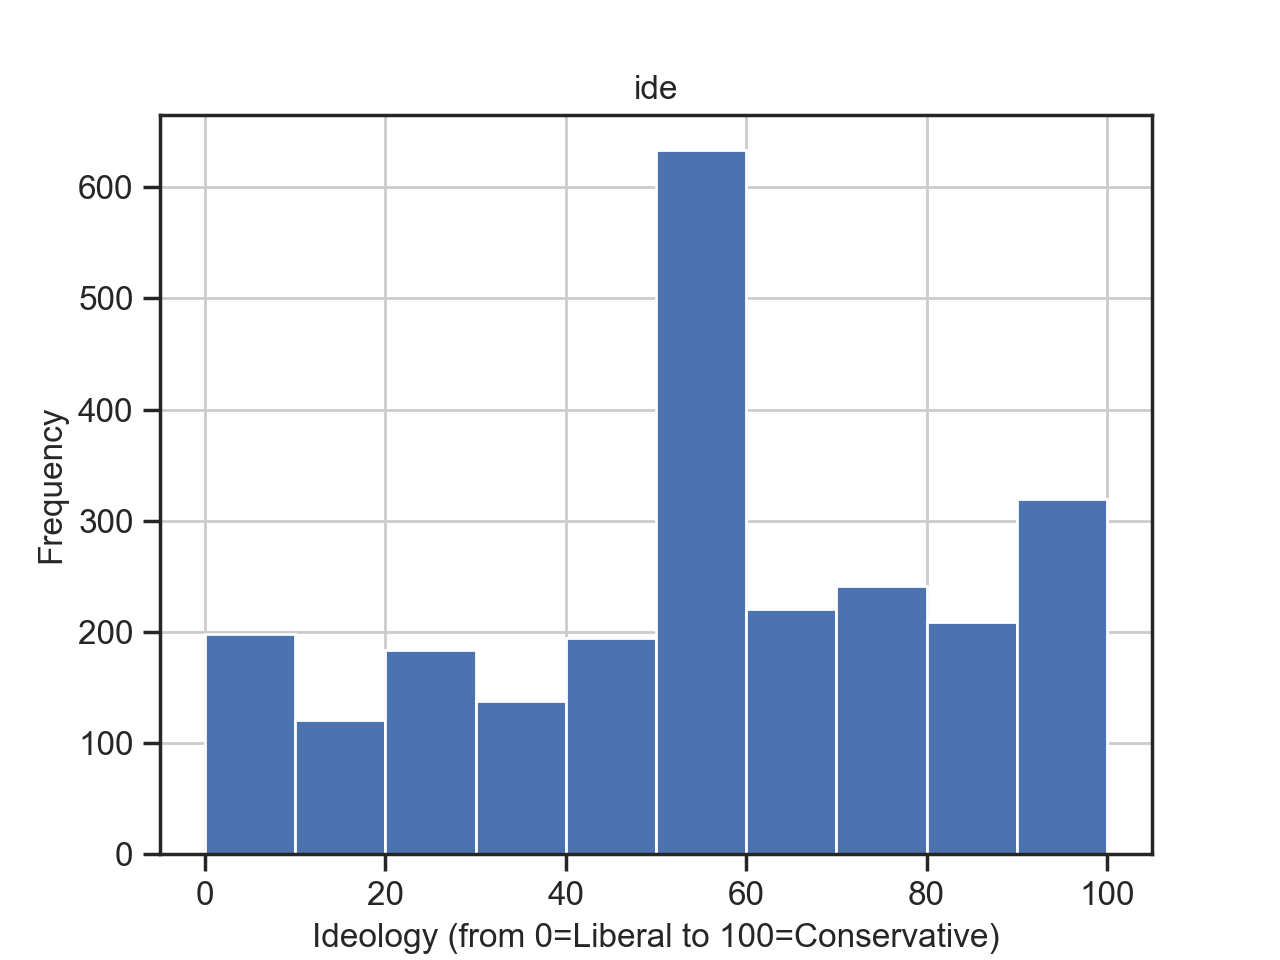

Text(0.5, 0, 'Ideology (from 0=Liberal to 100=Conservative)')

In [4]:
df.hist(column='ide')
plt.ylabel("Frequency")
plt.xlabel("Ideology (from 0=Liberal to 100=Conservative)")



#### $-$ Unpack data from dataframe

We want to use the row/column labels printed in the header above to extract data (typically matrices) and data labels (typically vectors). In this case, participants are rows and items are columns, which means participant-based labels are columns and item-based labels are rows.

In [6]:
# Extract rows with df.loc["target",:], only grabbing data corresponding to items
nitemlabel = 1
itemideology = df.loc["dem_rep", "RBU_1":"RBU_8"]
itemnum = np.arange(itemideology.size)

# Then remove these rows from the dataframe and continue
dftrim = df.iloc[nitemlabel:, :]

# Extract columns with df.target or df["target"] or df.loc[:,"target"]
partideology = dftrim.loc[:, "ide"]
ide_ms = dftrim.loc[:, "ide_ms"]
ide_abs = dftrim.loc[:, "ide_abs"]
partnum = np.arange(partideology.size)

# Extract data with df.loc[:,"datastart":"dataend"]
RdeltaB = dftrim.loc[:, "RBU_1":"RBU_8"]
Bpre = dftrim.loc[:, "PRE_1":"PRE_8"]
Bpost = dftrim.loc[:, "POST_1":"POST_8"]
sz = RdeltaB.shape
print(sz)

(2460, 8)


#### 1b $-$ Repack data into new dataframe in column-form
First, we expand every piece of data unpacked above to match the shape of the data. Then, we reshape all of them into columns and combine into a new dataset ready for analysis.

In [117]:
names = ["RdeltaB", "Bpre", "Bpost", "itemideology", "itemnum", \
         "partideology",'ide_ms', 'ide_abs', "partnum"]
data_packed = np.broadcast_arrays(RdeltaB, Bpre, Bpost, itemideology, itemnum)
cols = [np.tile(a, (sz[1],1)).T for a in [partideology, ide_ms, ide_abs, partnum]]
data_packed += cols

data_unpacked = np.vstack([np.reshape(a, (1,-1), order="C") for a in data_packed]).T
DATA = pd.DataFrame(data=data_unpacked, columns=names).apply(pd.to_numeric)
# DATA.loc[:, ["zBpre", "zpartideology"]] = DATA.loc[:, ["Bpre", "partideology"]].apply(stats.zscore)
DATA["zBpre"] = stats.zscore(DATA["Bpre"])
DATA["zpartideology"] = stats.zscore(DATA["partideology"])
DATA.head()

,RdeltaB,Bpre,Bpost,itemideology,itemnum,partideology,ide_ms,ide_abs,partnum,zBpre,zpartideology
0,0,100,100,1,0,0.0,1.0,100.0,0,1.718853,-1.94256
1,0,81,81,1,1,0.0,1.0,100.0,0,1.119744,-1.94256
2,15,31,46,2,2,0.0,1.0,100.0,0,-0.456859,-1.94256
3,32,12,44,2,3,0.0,1.0,100.0,0,-1.055968,-1.94256
4,8,49,57,3,4,0.0,1.0,100.0,0,0.110718,-1.94256


<IPython.core.display.Javascript object>


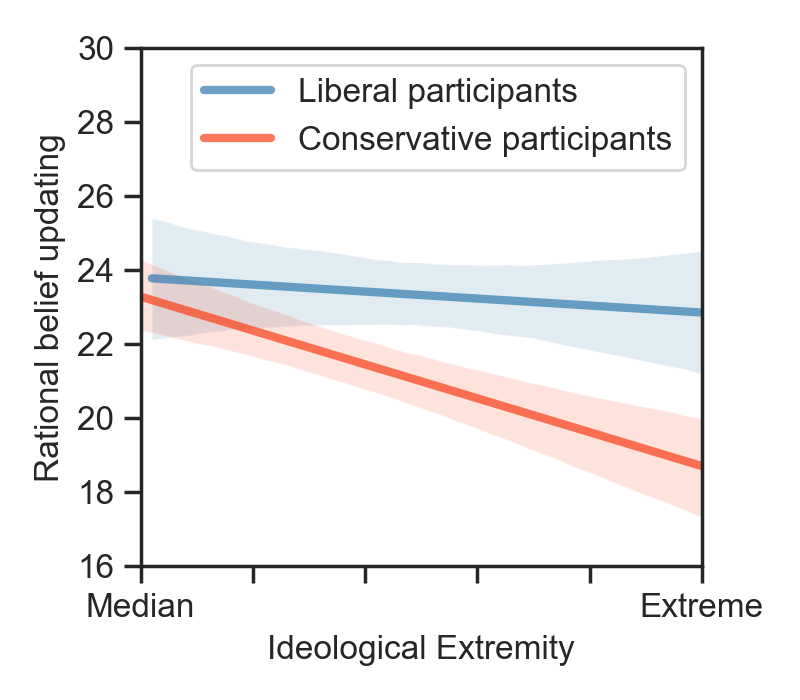

In [136]:
fig, ax = plt.subplots(1,1, figsize=(4,3.5))

sns.regplot(x=DATA.loc[DATA.ide_ms==1, "ide_abs"], y=DATA.loc[DATA.ide_ms==1, "RdeltaB"], scatter=False, \
            line_kws={"color":"#327AAE","alpha":0.7,"lw":3}, ax=ax)
sns.regplot(x=DATA.loc[DATA.ide_ms==2, "ide_abs"], y=DATA.loc[DATA.ide_ms==2, "RdeltaB"], scatter=False, \
            line_kws={"color":"#F93F17","alpha":0.7,"lw":3}, ax=ax)
ax.set_ylabel('Rational belief updating')
ax.legend(['Liberal participants', 'Conservative participants'], loc="upper right")
ax.set_xticklabels(['Median','','','','','Extreme']);
ax.set_xlabel('Ideological Extremity')
plt.ylim(16,30)
plt.tight_layout()


<IPython.core.display.Javascript object>


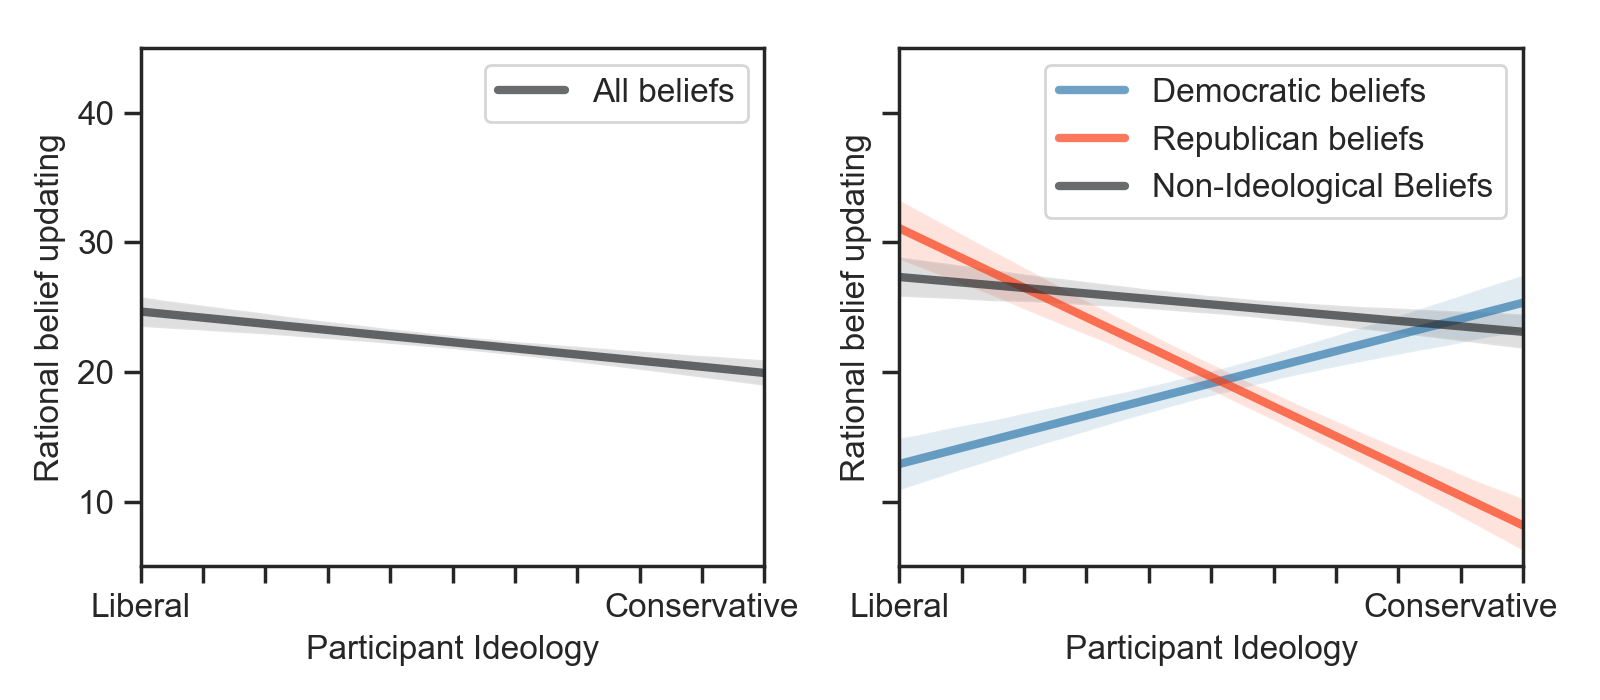

In [147]:
fig, ax = plt.subplots(1,2, figsize=(8,3.5), sharey=True)

sns.regplot(x=DATA.partideology.astype(float), y=DATA.RdeltaB, scatter=False, \
            line_kws={"color":"#2b2d2f","alpha":0.7,"lw":3}, ax=ax[0])

sns.regplot(x=DATA.loc[DATA.itemideology==1, "partideology"], y=DATA.loc[DATA.itemideology==1, "RdeltaB"], scatter=False, \
            line_kws={"color":"#327AAE","alpha":0.7,"lw":3}, ax=ax[1])
sns.regplot(x=DATA.loc[DATA.itemideology==2, "partideology"], y=DATA.loc[DATA.itemideology==2, "RdeltaB"], scatter=False, \
            line_kws={"color":"#F93F17","alpha":0.7,"lw":3}, ax=ax[1])
sns.regplot(x=DATA.loc[DATA.itemideology==3, "partideology"], y=DATA.loc[DATA.itemideology==3, "RdeltaB"], scatter=False, \
            line_kws={"color":"#2b2d2f","alpha":0.7,"lw":3}, ax=ax[1])
ax[1].legend(['Democratic beliefs', 'Republican beliefs', 'Non-Ideological Beliefs'], loc="upper right")
ax[0].legend(['All beliefs'], loc="upper right")

ax[0].set_xticks(list(range(0,101,10)))
ax[1].set_xticks(list(range(0,101,10)))
ax[1].set_xticklabels(['Liberal','','','','','','','','', 'Conservative']);
ax[0].set_xticklabels(['Liberal','','','','','','','','', 'Conservative']);
ax[0].set_xlabel('Participant Ideology')
ax[1].set_xlabel('Participant Ideology')
ax[0].set_ylabel('Rational belief updating')
ax[1].set_ylabel('Rational belief updating', labelpad=10)

plt.xlim(0,100)
plt.ylim(5,45)
plt.tight_layout()
# plt.savefig('H1.png', dpi=300)

<IPython.core.display.Javascript object>


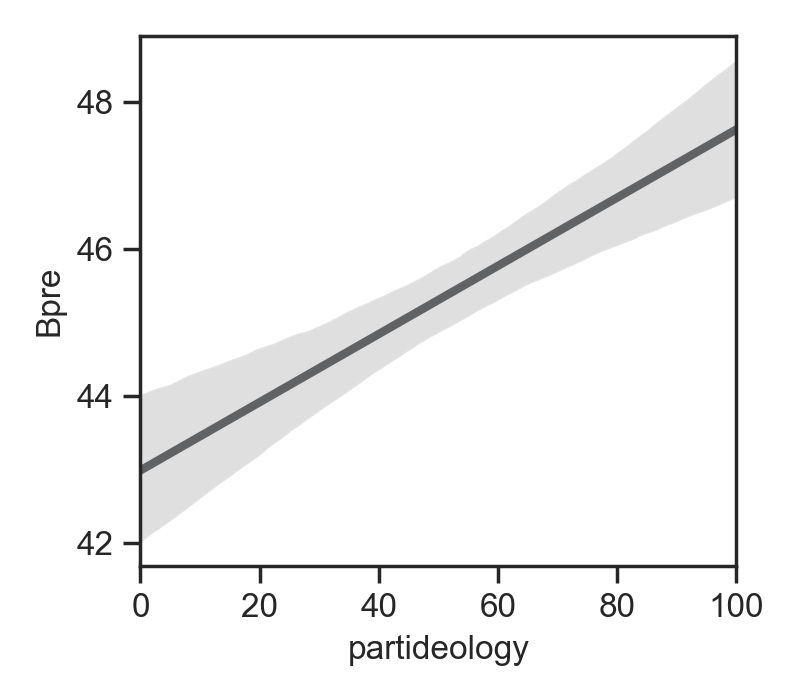

In [92]:
fig, ax = plt.subplots(1,1, figsize=(4,3.5))

sns.regplot(x=DATA.partideology, y=DATA.Bpre, scatter=False, \
            line_kws={"color":"#2b2d2f","alpha":0.7,"lw":3}, ax=ax)

# ax[0].set_xticks(list(range(0,101,10)))
# ax[1].set_xticks(list(range(0,101,10)))
# ax[1].set_xticklabels(['Liberal','','','','','','','','', 'Conservative']);
# ax[0].set_xticklabels(['Liberal','','','','','','','','', 'Conservative']);
# ax[0].set_xlabel('Participant Ideology')
# ax[1].set_xlabel('Participant Ideology')
# ax[0].set_ylabel('Rational belief updating')
# ax[1].set_ylabel('Rational belief updating', labelpad=5)

# plt.xlim(0,100)
# plt.ylim(5,45)
plt.tight_layout()
# plt.savefig('H1.png', dpi=300)

In [51]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython
# %R library(lme4)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
%R library(lmerTest)

array(['lmerTest', 'lme4', 'Matrix', 'tools', 'stats', 'graphics',
       'grDevices', 'utils', 'datasets', 'methods', 'base'], dtype='<U9')

- Push data to the R side (``FutureWarning: from_items is deprecated`` is normal)

In [132]:
%Rpush DATA

In [103]:
%%R

M <- lmer(RdeltaB ~ partideology + Bpre + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ partideology + Bpre + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 185455.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.4488 -0.4852  0.0899  0.6233  3.5502 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 323.700  17.99   
 itemnum  (Intercept)   9.608   3.10   
 Residual             585.468  24.20   
Number of obs: 19680, groups:  partnum, 2460; itemnum, 8

Fixed effects:
               Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)   5.005e+01  1.430e+00  1.925e+01  35.013   <2e-16 ***
partideology -2.002e-02  1.447e-02  2.459e+03  -1.383    0.167    
Bpre         -5.906e-01  6.268e-03  1.826e+04 -94.233   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) prtdlg
partideolgy -0.542       
Bpre        -0.188

In [104]:
%%R

M <- lmer(RdeltaB ~ partideology*itemideology + Bpre  + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ partideology * itemideology + Bpre + (1 | partnum) +  
    (1 | itemnum)
   Data: DATA

REML criterion at convergence: 185422.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5094 -0.4849  0.0901  0.6186  3.4766 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 323.717  17.992  
 itemnum  (Intercept)   7.548   2.747  
 Residual             584.297  24.172  
Number of obs: 19680, groups:  partnum, 2460; itemnum, 8

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                5.119e+01  3.145e+00  8.837e+00  16.277 6.82e-08 ***
partideology              -1.221e-01  2.231e-02  1.092e+04  -5.474 4.49e-08 ***
itemideology              -4.020e-01  1.258e+00  7.491e+00  -0.319    0.758    
Bpre                      -5.960e-01  6.328e-03  1.792e+04 -94.192  < 2e-16 ***
partideology:it

In [105]:
%%R

M <- lmer(RdeltaB ~ partideology:as.factor(itemideology) + Bpre  + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ partideology:as.factor(itemideology) + Bpre + (1 |  
    partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 185333.9

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5436 -0.4865  0.0929  0.6214  3.4936 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 323.76   17.993  
 itemnum  (Intercept)  25.64    5.063  
 Residual             580.85   24.101  
Number of obs: 19680, groups:  partnum, 2460; itemnum, 8

Fixed effects:
                                        Estimate Std. Error         df t value
(Intercept)                            5.115e+01  2.014e+00  1.039e+01  25.400
Bpre                                  -6.160e-01  6.613e-03  1.771e+04 -93.150
partideology:as.factor(itemideology)1 -1.341e-01  1.809e-02  5.017e+03  -7.410
partideology:as.factor(itemideology)2  7.792e-02  1.818e-02  5.097e+03   4.285
partideolog

In [133]:
DATA.head()

,RdeltaB,Bpre,Bpost,itemideology,itemnum,partideology,ide_ms,ide_abs,partnum,zBpre,zpartideology
0,0,100,100,1,0,0.0,1.0,100.0,0,1.718853,-1.94256
1,0,81,81,1,1,0.0,1.0,100.0,0,1.119744,-1.94256
2,15,31,46,2,2,0.0,1.0,100.0,0,-0.456859,-1.94256
3,32,12,44,2,3,0.0,1.0,100.0,0,-1.055968,-1.94256
4,8,49,57,3,4,0.0,1.0,100.0,0,0.110718,-1.94256


In [135]:
%%R

M <- lmer(RdeltaB ~ ide_abs:as.factor(ide_ms)  + (1 | partnum) + (1 | itemnum), data = DATA)
print(summary(M))


Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: RdeltaB ~ ide_abs:as.factor(ide_ms) + (1 | partnum) + (1 | itemnum)
   Data: DATA

REML criterion at convergence: 192729.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.7913 -0.5265 -0.0719  0.5419  3.8746 

Random effects:
 Groups   Name        Variance Std.Dev.
 partnum  (Intercept) 367.86   19.180  
 itemnum  (Intercept)  33.01    5.745  
 Residual             869.99   29.496  
Number of obs: 19680, groups:  partnum, 2460; itemnum, 8

Fixed effects:
                             Estimate Std. Error         df t value Pr(>|t|)
(Intercept)                  27.08183    2.76737   23.55278   9.786 9.05e-10
ide_abs:as.factor(ide_ms)1   -0.04824    0.02550 2457.01920  -1.892   0.0587
ide_abs:as.factor(ide_ms)2   -0.08102    0.02643 2457.01922  -3.065   0.0022
                              
(Intercept)                ***
ide_abs:as.factor(ide_ms)1 .  
ide_abs:as.factor(ide_ms)2 **

In [142]:
DATA.head()

,RdeltaB,Bpre,Bpost,itemideology,itemnum,partideology,ide_ms,ide_abs,partnum,zBpre,zpartideology
0,0,100,100,1,0,0.0,1.0,100.0,0,1.718853,-1.94256
1,0,81,81,1,1,0.0,1.0,100.0,0,1.119744,-1.94256
2,15,31,46,2,2,0.0,1.0,100.0,0,-0.456859,-1.94256
3,32,12,44,2,3,0.0,1.0,100.0,0,-1.055968,-1.94256
4,8,49,57,3,4,0.0,1.0,100.0,0,0.110718,-1.94256
